Classificador - separa pacientes em curados e não curados
======================================================

**Autores:** Rafael Anis, Glauber Nascimento, Maria Emily Gomes

## Introdução

<p style="text-align:justify;"> O objetivo deste notebook é passar por todos os passos necessários para a construção de um modelo que classifique os pacientes em curados e não curados. Dessa forma, apenas pacientes não curados seriam levado ao modelo regressor que que prevê o tempo, em meses, de sobrevida. O tipo de câncer escolhido foi o <strong>Câncer de pulmão de células não pequenas</strong>.

 <p style="text-align:justify;"> Para o classificador, dois possíveis algoritmos serão investigados: <code>Regressão Logística</code> e <code>Floresta aleatória</code>. A <b>otimização de hiperparâmetros</b> será feita com uso do optuna. A <b>métrica</b> utilizada para medir a perfomance dos modelos será a área abaixo de uma curva precisão-sensibilidade (<b>auc - pr</b>), do inglês area under the curve for precision-recall curve). 


<p style="text-align:justify;"> Por fim, os modelos com hiperparâmetros otimizados serão comparados entre si e com o baseline, através de matrizes de confusão e de gráficos Precision-Recall.

## Carregando os dados e importando bibliotecas

<p style="text-align:justify;"> Vamos iniciar importando algumas bibliotecas principais e carregando nossos dados, como já explicado em notebooks anteriores. Em seguida faremos split dos dados.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv("msk_met_2021_clinical_data (1).tsv", sep = "\t")

df['Curado'] = pd.NA
df ['Sobrevivencia (Meses)'] = pd.NA

for i, meses in enumerate(df['Overall Survival (Months)']):
    
    if meses >= 60:
        df.loc [i, 'Curado'] = 1
        
    else:
        if df.loc [i, 'Overall Survival Status'] == '1:DECEASED':
            df.loc [i, 'Curado'] = 0
            df.loc [i, 'Sobrevivencia (Meses)'] = meses

ATRIBUTOS = [                  
        "Age at Surgical Procedure",           
        "Fraction Genome Altered",              
        "Met Count",                            
        "Met Site Count",                       
        "MSI Score",                   
        "Mutation Count",              
        "TMB (nonsynonymous)"
        ] 
TARGET = ['Curado']

df = df[df["Cancer Type"] == "Non-Small Cell Lung Cancer"]

colunas = ATRIBUTOS + TARGET
df = df[colunas]
df = df.dropna()
df = df.convert_dtypes()

### Split dos dados

<p style="text-align:justify;"> Considerando que o target do modelo é desbalanceado no dataset (muitos dados de pacientes que faleceram do que foram curados), iremos fazer um split dos curados e falecidos separados, e depois juntar os dois. 

Desta forma, asseguraremos que a proporção de vivos para mortos é a mesma no split e no treino.

Separando em curados e não curados.

In [2]:
curados = df[df["Curado"] == 1]
nao_curados = df[df["Curado"] == 0]

#### Split do não curados

In [3]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2424

indices_nao_curados = nao_curados.index
indices_treino_nao_curados, indices_teste_nao_curados = train_test_split(
    indices_nao_curados, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_nao = df.loc[indices_treino_nao_curados]
df_teste_nao = df.loc[indices_teste_nao_curados]

#### Split dos curados

In [4]:
indices_curados = curados.index
indices_treino_curados, indices_teste_curados = train_test_split(
    indices_curados, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_curados = df.loc[indices_treino_curados]
df_teste_curados = df.loc[indices_teste_curados]

#### Juntando os splits

In [5]:
df_treino = pd.concat([df_treino_nao, df_treino_curados], ignore_index= True)
df_teste = pd.concat([df_teste_nao, df_teste_curados], ignore_index= True)


X_treino = df_treino.reindex(ATRIBUTOS, axis=1).values.astype(int)
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel().astype(int)

X_teste = df_teste.reindex(ATRIBUTOS, axis=1).values.astype(int)
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel().astype(int)

## Optuna para os classificadores de curados

<p style="text-align:justify;">O objetivo do optuna é otimizar hiperparâmetros para os modelos <code>Regressão Logística</code> e <code>Floresta aleatória</code>. Essa otimização será feito considerando a métrica <strong>auc-pr</strong>.

### Regressão Logística

#### Criando instância de modelo para regressão logística

<p style="text-align:justify;"> Começaremos criando a instância do modelo, utilizando hiperparâmetros de acordo com estudo do módulo sobre <code>Logistic Regression</code> do scikit-learn. [1]

In [6]:
import optuna
from sklearn.linear_model import LogisticRegression

# Função para criar uma instância do modelo de Regressão Logística
def cria_instancia_modelo_rlog(trial):
    """Cria uma instância do modelo de Regressão Logística.
    Args:
      trial: objeto tipo Trial do optuna.
    Returns: Uma instância do modelo desejado.
    """
    # Sugere os hiperparâmetros
    parametros = {
        'C' : trial.suggest_float('C', 1e-5, 1e3, log=True),
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver' : trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga']),
        'class_weight' : trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_iter' : trial.suggest_int('max_iter', 500, 1000),
        'class_weight' : trial.suggest_categorical('class_weight', [None, 'balanced']),

  
        "n_jobs": -1, #-1 pra HPC, mas se for rodar no pc. utilzar uns 4 ou 5
        "random_state": SEMENTE_ALEATORIA,
        
    }
    if parametros['penalty'] == 'elasticnet':
        parametros['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        parametros['l1_ratio'] = None

    # Garante que o solver seja compatível com a penalidade escolhida
    if parametros['penalty'] == 'l1' and parametros['solver'] not in ['liblinear', 'saga']:
        raise optuna.TrialPruned()
    if parametros['penalty'] == 'elasticnet' and parametros['solver'] != 'saga':
        raise optuna.TrialPruned()

    model = LogisticRegression(**parametros)
    return model


#### Função objetivo

<p style="text-align:justify;">Esta função medirá o auc abaixo da curva precisão - sensibilidade de um dado modelo. Esta área pode ir de 0 a 1, sendo que quando mais próximo de 1, melhor a perfomance do modelo.

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def funcao_objetivo (trial, X_teste, y_teste, X_treino, y_treino):
    
    modelo_rlog = cria_instancia_modelo_rlog(trial)
    modelo_rlog.fit (X_treino, y_treino)
    y_verdadeiro = y_teste
    probabilidades = modelo_rlog.predict_proba(X_teste)
    y_scores = probabilidades[:, 1] # probabilidade somente das classes positivas

    precision, recall, thresholds = precision_recall_curve(
        y_verdadeiro, y_scores, pos_label =1)

    auc_pr = auc(recall, precision)

    return auc_pr

#### Otimização de parâmetros

Para a otimização seguiremos 3 últimos passos:

1) Definir nosso objeto de estudo de nome **classicador_rlog** e definir que estamos buscando o maior valor de auc por maximize
2) Criar uma funcão objetivo parcial que contém apenas um argumento (o nosso **trial**)
3) Rodar a função parcial N vezes

In [8]:
from optuna import create_study

NOME_DO_ESTUDO = "classificador_rlog"

objeto_de_estudo_rlog = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_teste, y_teste, X_treino, y_treino)

[I 2024-11-17 21:29:53,087] Using an existing study with name 'classificador_rlog' instead of creating a new one.


In [9]:
NUM_TENTATIVAS = 1000

objeto_de_estudo_rlog.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-11-17 21:29:53,767] Trial 1000 finished with value: 0.5358851674641149 and parameters: {'C': 1.3677165466790563e-05, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 694, 'l1_ratio': 0.12259745959056655}. Best is trial 261 with value: 0.5358851674641149.
[I 2024-11-17 21:29:54,069] Trial 1001 finished with value: 0.5358851674641149 and parameters: {'C': 2.6557802380592483e-05, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None, 'max_iter': 709, 'l1_ratio': 0.3964017058223491}. Best is trial 261 with value: 0.5358851674641149.
/home/rafael24018/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-17 21:29:54,422] Trial 1002 finished with value: 0.10309167316809648 and parameters: {'C': 3.9530221135884157e-05, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None, 'max_iter': 649, 'l1_ratio': 0

#### Observando os resultados

Vamos analizar nosso melhor trial e em consequência os melhores hiperparâmetros que o optuna foi capaz de encontrar

In [10]:
melhor_trial_rlog = objeto_de_estudo_rlog.best_trial

print(f"Número do melhor trial: {melhor_trial_rlog.number}")
print(f"Parâmetros do melhor trial: {melhor_trial_rlog.params}")

Número do melhor trial: 261
Parâmetros do melhor trial: {'C': 1.3234159710510002e-05, 'penalty': 'elasticnet', 'solver': 'saga', 'class_weight': None, 'max_iter': 650, 'l1_ratio': 0.1563381164751073}


Vamose então medir a métrica **auc-pr** para o modelo otimizado.

In [11]:
modelo_rlog = LogisticRegression(C =1.3234159710510002e-05, penalty = 'elasticnet', solver = 'saga',
                                 class_weight = None,max_iter= 650, l1_ratio = 0.1563381164751073,
                                 random_state = SEMENTE_ALEATORIA)
modelo_rlog.fit(X_treino, y_treino)

y_verdadeiro = y_teste
probabilidades = modelo_rlog.predict_proba(X_teste)
y_scores = probabilidades[:, 1] # probabilidade somente das classes positivas

precision, recall, thresholds = precision_recall_curve(
    y_verdadeiro, y_scores, pos_label =1)

auc_pr = auc(recall, precision)

print (auc_pr)

0.5358851674641149


### Floresta aleatória


<p style="text-align:justify;"> Repetiremos o mesmo processo agora, alterando apenas os hiperparâmetros e nomes de variáveis. Os hiperparâmetros foram selecionados através do estudo do modulo sobre <b>Random Forest Classifier</b> do scikit [2].

#### Criando instância de modelo para floresta aleatória


In [12]:
from sklearn.ensemble import RandomForestClassifier

def cria_instancia_modelo_rf(trial):
    """Cria uma instância do modelo.
    Args:
      trial: objeto tipo Trial do optuna.
    Returns: Uma instância do modelo desejado. """
    parametros = {
        "n_estimators": trial.suggest_int("num_arvores", 10, 100, log = True),
        "criterion": trial.suggest_categorical(
            "critério", ["gini", "entropy", "log_loss"]
        ),
        "min_samples_split": trial.suggest_int(
            "min_exemplos_split", 2, 20, log=True
        ),
        "max_depth": trial.suggest_categorical(
            'max_depth', [None] + list(range(3, 21)),
        ), 
        "min_samples_leaf": trial.suggest_int(
            "min_exemplos_folha", 1, 20, log=True
        ),
        'min_impurity_decrease': trial.suggest_float(
            'min_impurity_decrease', 0.0, 0.2
        ),
        "max_features": trial.suggest_categorical (
            'max_atributos', ['sqrt', 'log2', None]
        ),
        
        "n_jobs": -1, #-1 pra HPC, mas se for rodar no pc. utilzar uns 4 ou 5
        "bootstrap": True,
        "random_state": SEMENTE_ALEATORIA,
    }
    model = RandomForestClassifier(**parametros)
    return model

#### Função objetivo

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def funcao_objetivo (trial, X_teste, y_teste, X_treino, y_treino):
    
    modelo_rf = cria_instancia_modelo_rf(trial)
    modelo_rf.fit (X_treino, y_treino)
    y_verdadeiro = y_teste
    probabilidades = modelo_rf.predict_proba(X_teste)
    y_scores = probabilidades[:, 1] # probabilidade somente das classes positivas

    precision, recall, thresholds = precision_recall_curve(
        y_verdadeiro, y_scores, pos_label =1)

    auc_pr = auc(recall, precision)

    return auc_pr

#### Otimização de parâmetros

In [26]:
NOME_DO_ESTUDO = "classicador_rf"

objeto_de_estudo_rf = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_teste, y_teste, X_treino, y_treino)

NUM_TENTATIVAS = 500

objeto_de_estudo_rf.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-11-17 21:37:29,631] Using an existing study with name 'classicador_rf' instead of creating a new one.
[I 2024-11-17 21:37:30,616] Trial 1500 finished with value: 0.18148186815639547 and parameters: {'num_arvores': 23, 'critério': 'entropy', 'min_exemplos_split': 14, 'max_depth': 3, 'min_exemplos_folha': 20, 'min_impurity_decrease': 0.012234770780156154, 'max_atributos': 'sqrt'}. Best is trial 566 with value: 0.5416666666666666.
[I 2024-11-17 21:37:31,011] Trial 1501 finished with value: 0.5358851674641149 and parameters: {'num_arvores': 19, 'critério': 'entropy', 'min_exemplos_split': 13, 'max_depth': 13, 'min_exemplos_folha': 17, 'min_impurity_decrease': 0.01817243493624015, 'max_atributos': 'log2'}. Best is trial 566 with value: 0.5416666666666666.
[I 2024-11-17 21:37:31,396] Trial 1502 finished with value: 0.1485178000101321 and parameters: {'num_arvores': 18, 'critério': 'entropy', 'min_exemplos_split': 15, 'max_depth': 3, 'min_exemplos_folha': 18, 'min_impurity_decrease': 

#### Observando os resultados

Printando hiperparâmetros otimizados

In [15]:
melhor_trial_rf = objeto_de_estudo_rf.best_trial

print(f"Número do melhor trial: {melhor_trial_rf.number}")
print(f"Parâmetros do melhor trial: {melhor_trial_rf.params}")

Número do melhor trial: 566
Parâmetros do melhor trial: {'num_arvores': 17, 'critério': 'entropy', 'min_exemplos_split': 15, 'max_depth': 5, 'min_exemplos_folha': 12, 'min_impurity_decrease': 0.010398092577349069, 'max_atributos': 'log2'}


Métrica auc-pr

In [16]:
modelo_rf = RandomForestClassifier(n_estimators = 17,
criterion = 'entropy', min_samples_split = 15,
max_depth = 5, min_samples_leaf = 12, 
min_impurity_decrease = 0.010398092577349069, 
max_features = 'log2',
random_state = SEMENTE_ALEATORIA)

modelo_rf.fit(X_treino, y_treino)

y_verdadeiro = y_teste
probabilidades = modelo_rf.predict_proba(X_teste)
y_scores = probabilidades[:, 1] # probabilidade somente das classes positivas

precision, recall, thresholds = precision_recall_curve(
    y_verdadeiro, y_scores, pos_label =1)

auc_pr = auc(recall, precision)

print (auc_pr)

0.5416666666666666


## Analisando os resultados

<p style="text-align:justify;"> Na seção de <b> Optuna para os classificadores de curados </b> os modelos de regressão logística e floresta aleatória foram otimizados e possuem métrica (auc-pr) igual a 0.377 e 0.553. Seguindo essa métrica, o algoritmo de floresta aleatória parece mais promissor para o modelo classificador.

<p style="text-align:justify;"> Não obstante, o objetivo desta seção é comparar de forma mais visual esses modelos com o modelo baseline também. A comparação será feita por <b>Matriz de confusão</b> e <b>Gráfico Precision-Recall</b>.

### Importando bibliotecas métricas e gráficas

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.metrics import auc

### Matriz de confusão e acurácia

<p style="text-align:justify;"> Vamos plotar a matriz confusão dos 3 modelos (baseline, regressão logística e floresta aleatória) e então analisar o que tem em comum ou diferente. Vamos aproveitar e calcular a acurácia de cada modelo.

Para começar, temos que definir a ordem dos labels da coluna `Curados` (0,1).

In [18]:
ordem_labels = [0, 1]

#### Baseline

<p style="text-align:justify;"> O modelo baseline é o mais simples, que prevê apenas o dado mais frequente que ele observou durante o treino. Ou seja, ele prevê a moda dos dados. No caso do nosso projeto, a moda será o paciente falecido, então ele irá assumir que todos os pacientes estão nesse estado.

Acurácia do modelo baseline = 92.82%


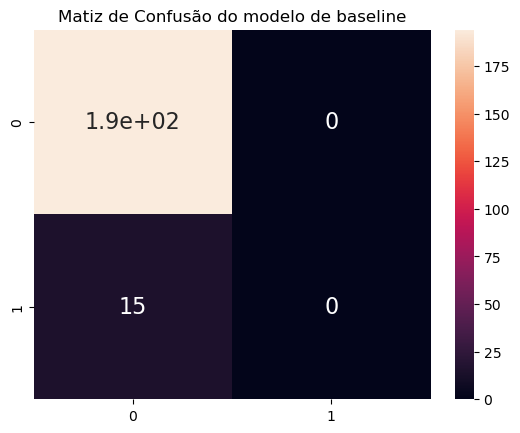

In [19]:
from sklearn.dummy import DummyClassifier

modelo_baseline_class = DummyClassifier()

modelo_baseline_class.fit(X_treino, y_treino)

y_verdadeiro_base = y_teste
y_previsao_base = modelo_baseline_class.predict(X_teste)

matriz_conf_base = confusion_matrix(y_verdadeiro_base, y_previsao_base, labels= [0,1])
df_conf = pd.DataFrame(matriz_conf_base, ordem_labels, ordem_labels)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}).set(title = "Matiz de Confusão do modelo de baseline")

acuracia = accuracy_score(y_verdadeiro_base, y_previsao_base)

print(f"Acurácia do modelo baseline = {(acuracia*100):.2f}%")

#### Regressor Linear

O modelo de regressão logística estima a probabilidade de ocorrência de um evento. dessa forma, ele prevê se a pessoa irá ser curada ou não.

Acurácia do modelo baseline = 92.82%


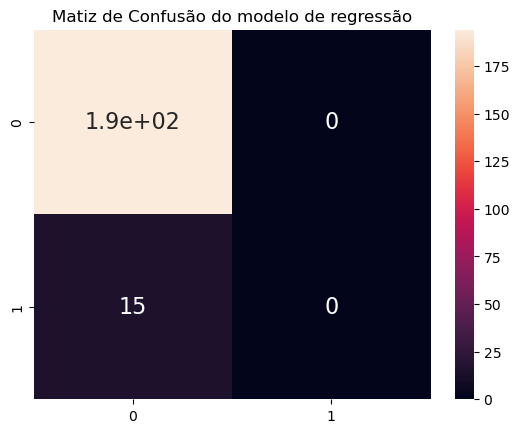

In [20]:
modelo_rlog = LogisticRegression(C =1.3234159710510002e-05, penalty = 'elasticnet', solver = 'saga',
                                 class_weight = None,max_iter= 650, l1_ratio = 0.1563381164751073,
                                 random_state = SEMENTE_ALEATORIA)
modelo_rlog.fit(X_treino, y_treino)

y_verdadeiro_rlog = y_teste
y_previsao_rlog = modelo_rlog.predict(X_teste)

matriz_conf_rlog = confusion_matrix(y_verdadeiro_rlog, y_previsao_rlog, labels= [0, 1])
df_conf = pd.DataFrame(matriz_conf_rlog, ordem_labels, ordem_labels)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}).set(title = "Matiz de Confusão do modelo de regressão")

acuracia = accuracy_score(y_verdadeiro_base, y_previsao_base)

print(f"Acurácia do modelo baseline = {(acuracia*100):.2f}%")

#### Floresta aleatória

O algoritmo floresta aleatória de classificação é muito similar à sua contrapartida regressora, com duas diferenças notáveis:

1.  As árvores da floresta são classificadores e não regressores (o que faz todo sentido!).
2.  A previsão final não é a média da previsão de cada árvore, mas sim a moda.

Acurácia do modelo floresta aleatória = 92.82%


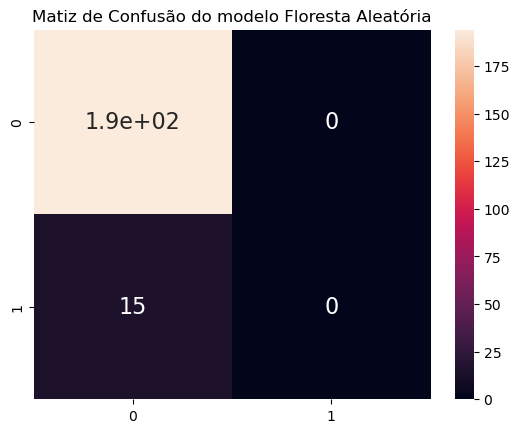

In [21]:
modelo_rf = RandomForestClassifier(n_estimators = 17,
criterion = 'entropy', min_samples_split = 15,
max_depth = 5, min_samples_leaf = 12, 
min_impurity_decrease = 0.010398092577349069, 
max_features = 'log2',
random_state = SEMENTE_ALEATORIA)

modelo_rf.fit(X_treino, y_treino)

y_verdadeiro_rf = y_teste
y_previsao_rf = modelo_rf.predict(X_teste)

matriz_conf_rf = confusion_matrix(y_verdadeiro_rf, y_previsao_rf, labels=[0,1])
df_conf = pd.DataFrame(matriz_conf_rf,[0,1], [0,1])
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}).set(title = "Matiz de Confusão do modelo Floresta Aleatória")

acuracia = accuracy_score(y_verdadeiro_base, y_previsao_base)

print(f"Acurácia do modelo floresta aleatória = {(acuracia*100):.2f}%")

#### Comparando as matrizes

<p style="text-align:justify;"> Qualitativamente, pela matriz de confusão, e quantitativamente, pela acurácia, por esse método de avaliação, se concluria que os três modelos possuem a mesma perfomance. Portanto, isso mostra a importância de considerar outras métricas, que não consideram apenas os outputs em si do modelo, mas também as probabilidades/scores por trás disso. É aí que entra a <strong>Curva de Precisão-Sensibilidade</strong>.

### Curva de Precisão-Sensibilidade

#### Vendo conceitos

Antes de olhar a curva, vale a pena lembrar o que são as métricas precisão e sensibilidade. [3]

$$
\mathrm{Precisão = \frac{VP}{VP + FP}}
$$

**O que mede**: dos exemplos classificados com o rótulo 1 (positivo), quantos foram corretamente identificados.


$$
\mathrm{Sensibilidade = \frac{VP}{VP + FN}}
$$

**O que mede**: quantos exemplos que possuem rótulo 1 (positivo) foram corretamente identificados.


Assim, ambas as métricas se tornam muito útil para o caso do dataset estudado, onde a quantidade de classe 1 é tão rara.

<p style="text-align:justify;"> Já um <strong> gráfico de precisão-sensibilidade</strong> analisa essas duas métricas em diferentes limiares (e não apenas no padrão 0.5), o que nos oferece uma visão mais ampla do equilíbrio entre essas duas métricas. A <strong> métrica AUC</strong>, por sua vez, mostra a perfomance geral do modelo ao longo desses possíveis "thresholds".

Por fim, pelo gráfico, um limiar diferente de 0.5 poderia ser escolhido, se isso mostrar um balanço entre precision e recall. 


#### Plotando o gráfico

Para plotar o gráfico devemos encontrar os <strong>y-scores</strong> de cada modelo, isto é a probabilidade para cada instância ser positiva.

In [22]:
probabilidades_baseline = modelo_baseline_class.predict_proba(X_teste)
y_scores_baseline = probabilidades_baseline[:, 1] # probabilidade somente das classes positivas

probabilidade_rlog = modelo_rlog.predict_proba(X_teste)
y_scores_rlog = probabilidade_rlog[:, 1] 

probabilidades_rf = modelo_rf.predict_proba(X_teste)
y_scores_rf = probabilidades_rf[:, 1]

precision_baseline, recall_baseline, _ = precision_recall_curve(y_verdadeiro_base, y_scores_baseline)
precision_rlog, recall_rlog, _ = precision_recall_curve(y_verdadeiro_rlog, y_scores_rlog)
precision_rf, recall_rf, _ = precision_recall_curve(y_verdadeiro_rf, y_scores_rf)

Vamos plotar o gráfico

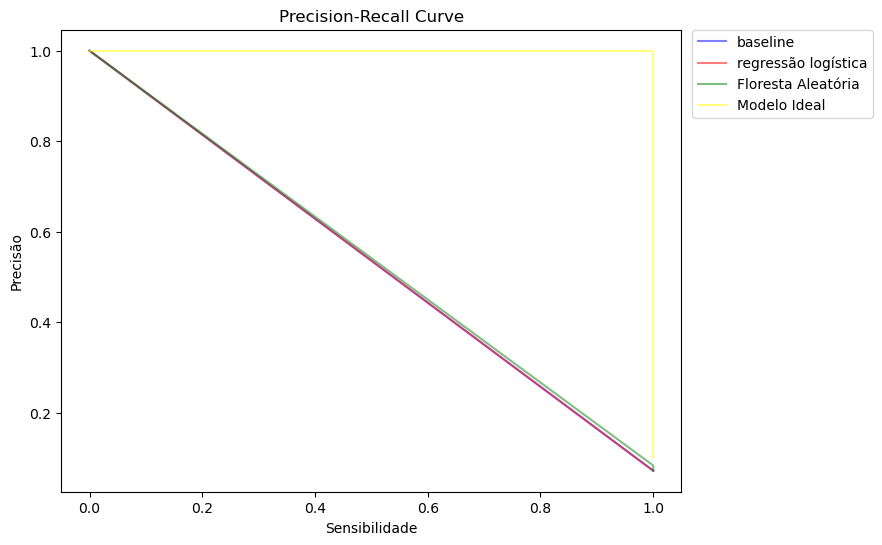

In [23]:
import matplotlib.pyplot as plt

recall_ideal = [0.0 , 1.0 , 1.0]
precision_ideal = [1.0, 1.0, 0.1]


plt.figure(figsize=(8, 6))
plt.plot(recall_baseline, precision_baseline, color='blue',alpha= 0.5, label='baseline')
plt.plot(recall_rlog, precision_rlog, color='red',alpha= 0.5, label='regressão logística')
plt.plot(recall_rf, precision_rf, color='green', alpha= 0.5, label='Floresta Aleatória')
plt.plot(recall_ideal, precision_ideal, color='yellow', alpha= 0.5, label='Modelo Ideal')
plt.xlabel('Sensibilidade')
plt.ylabel('Precisão')
plt.title('Precision-Recall Curve')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.32, 1.015))
plt.show()

<p style="text-align:justify;">Visualmente, aparenta que o modelo de regressão logística esta igual ao modelo baseline. Por outro lado, a floresta aleatória parece apresentar uma curva um pouca acima das demais, sugerindo uma melhor perfomance. Podemos analisar isso também de forma qualitativa, calculando o área abaixo das curvas (<strong>AUC</strong>). 

In [24]:
auc_baseline = auc(recall_baseline, precision_baseline)
auc_rlog = auc(recall_rlog, precision_rlog)
auc_rf = auc(recall_rf, precision_rf)

print (f'AUC do baseline = {auc_baseline}')
print (f'AUC da regressão logística = {auc_rlog}')
print (f'AUC da floresta aleatória = {auc_rf}')

AUC do baseline = 0.5358851674641149
AUC da regressão logística = 0.5358851674641149
AUC da floresta aleatória = 0.5416666666666666


<p style="text-align:justify;">Com esses números fica claro que realmente a regressão logística (<i>r_log</i>) apresenta a mesma AUC que a baseline. Não obstante, a floresta aleatória, mesmo que minimamente, apresenta uma maior perfomance.

Ademais, podemos aproveitar e verificar os y-scores dos 3 modelos, será que o modelo de regressão logística e baseline também possuem mesmo y-score? 


#### Analisando os y-scores


<p style="text-align:justify;"> Com <code>np.unique</code>, podemos analisar todas os valores de y-score diferentes para aquele modelo (analisando também, se esse valor muda ou permanece o mesmo para todas instância. Lembrando que o y-score é a probabilidade do paciente sendo analisado ser curado.

In [25]:
unique_scores_baseline = np.unique(y_scores_baseline)
unique_scores_rf = np.unique(y_scores_rf)
unique_scores_rlog = np.unique(y_scores_rlog)

print (f'y-score para o modelo baseline = {unique_scores_baseline}')
print (f'y-score para o modelo de floresta aleatória = {unique_scores_rf}')
print (f'y-score para o modelo de regressão logística = {unique_scores_rlog}')


y-score para o modelo baseline = [0.07112299]
y-score para o modelo de floresta aleatória = [0.06502533 0.06935305]
y-score para o modelo de regressão logística = [0.16099242]


<p style="text-align:justify;">Algumas informações podem ser tiradas dessa análise. Primeiramente, os modelos baseline e <i>r_log</i> possuem apenas um y-score, isto é, independente do paciente teste, todos eles foram concedidos a mesma probabilidade de ser curado ou não por cada modelo. Interessante analisar que este não o caso da floresta aleatória, ele apresenta ser um pouco mais sensível ao dar valores diferentes a pacientes.

<p style="text-align:justify;"> Por outro lado, destes y-scores, a floresta aleatória apresentou uma probabilidade ínfima de definir um paciente como classe 1, se assimilando muito ao valor baseline. É como se ele dissesse com muita certeza que o paciente não vai sobreviver mais que 5 anos. 

<p style="text-align:justify;">Já o modelo de regressão logística se mostra um pouco mais coerente. Apesar do valor também baixo do y-score, dos três ele é o que se aproxima mais de uma visão realista de que há uma possibilidade de o paciente não ser com toda certeza parte da classe 0, mas talvez seja curado. 

## Conclusão 

<p style="text-align:justify;"> Dessa forma, mesmo com a optimização dos hiperparâmetros dos modelo classificador <strong>Regressão Logística</strong> suas perfomance é a mesma da que o modelo baseline, quando utilizado a métrica de <strong>área abaixo da curva de Precisão-Sensibilidade</strong> - e também se utilizassemos a métrica de <strong>acurácia</strong>. Por outro lado, uma diferença nos modelos é percebida ao se analisar os <strong>y-scores</strong> de cada modelo. Por este parâmetro, o modelo de regressão logística se destaca como com maior potencial de distinguir um paciente curado de um não curado. Para isso, porém, seriam necessário mais dados, principalmente de pacientes curados, e possivelmente mais atributos que ajudassem no discernimento feito pela máquina.
    
<p style="text-align:justify;"> Não obstante, o modelo otimizado <strong>Floresta Aleatória</strong> é o que demonstra o maior valor de AUC, e assim se destaca entre os modelos e será utilizado no projeto final, por mostrar o melhor equílibrio entre precisão e sensibilidade.

## Referências
[1] https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

[2] https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[3] ATP-203 10.0 - Outras métricas de classificação; Autor: Daniel R. Cassar